In [1]:
# Libraries and dependencies

from __future__ import division, print_function, unicode_literals, absolute_import
from IPython.display import clear_output
from six.moves import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [2]:
# Dataset import

dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64

In [5]:
dftrain.loc[0], y_train.loc[0]

(sex                          male
 age                          22.0
 n_siblings_spouses              1
 parch                           0
 fare                         7.25
 class                       Third
 deck                      unknown
 embark_town           Southampton
 alone                           n
 Name: 0, dtype: object,
 0)

In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
dftrain.shape

(627, 9)

<AxesSubplot:>

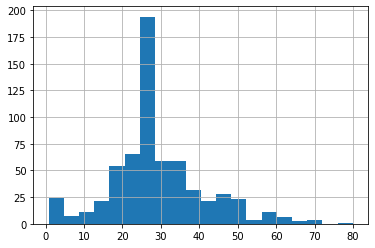

In [8]:
dftrain.age.hist(bins=20)

## Insights

* Most passengers are around between 20 and 40 years old
* An outlier in a passenger close to 80 years old
* The highest number of passengers have around 25 years old

<AxesSubplot:>

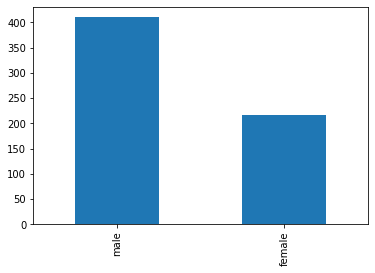

In [9]:
dftrain.sex.value_counts().plot(kind='bar')

## Insights

* More male than female passengers, consistent with the decade

<AxesSubplot:>

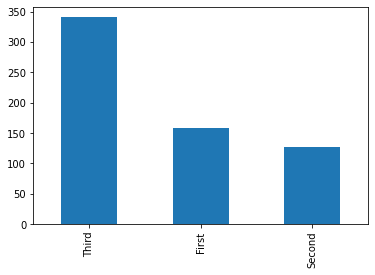

In [10]:
dftrain['class'].value_counts().plot(kind='bar')

## Insights
* More passengers taveled in third class
* More passenger in first class than in second class, which is interesting


<AxesSubplot:xlabel='sex'>

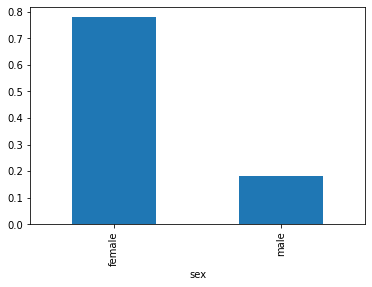

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='bar')

## Insights

* The survival rate for female passengers is 5 times higher which is consitent to the *women and children first"* policy of that time

In [15]:
# Builds the regression model
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
feature_columns = []

# Encoding categorical columns
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
    

In [16]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [19]:
# Input function
# epochs -> same slice of data but in different order, careful with overfittingb
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [21]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

# Train model
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])

0.75757575


In [22]:
result

{'accuracy': 0.75757575,
 'accuracy_baseline': 0.625,
 'auc': 0.8338537,
 'auc_precision_recall': 0.7880852,
 'average_loss': 0.47151005,
 'label/mean': 0.375,
 'loss': 0.4626003,
 'precision': 0.68421054,
 'prediction/mean': 0.3680111,
 'recall': 0.65656567,
 'global_step': 200}

In [23]:
prediction = list(linear_est.predict(eval_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Juanjo\AppData\Local\Temp\tmp6efha1fu\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [25]:
prediction[0]

{'logits': array([-2.6242833], dtype=float32),
 'logistic': array([0.06759182], dtype=float32),
 'probabilities': array([0.9324082 , 0.06759185], dtype=float32),
 'class_ids': array([0], dtype=int64),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1]),
 'all_classes': array([b'0', b'1'], dtype=object)}

In [27]:
prediction[0]['probabilities'][1]

0.067591846

This passenger has a 6% chance of survival

In [28]:
y_eval.loc[0]

0

Model was accurate for this passenger

In [34]:
# Let's try to find a survived female passenger

print(dfeval.loc[2])
print(y_eval[2])

print(prediction[2]['probabilities'])

sex                        female
age                          58.0
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
1
[0.30744773 0.69255227]
